In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gspread
from df2gspread import df2gspread as d2g
from oauth2client.service_account import ServiceAccountCredentials

In [35]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

my_mail = 'bar.zar.1566@gmail.com'
path_to_credentials = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-z-baranchieva/untitled_folder/final_project/myfinalproject-430306-7d590752618f.json'
credentials = ServiceAccountCredentials.from_json_keyfile_name(path_to_credentials, scope)
gs = gspread.authorize(credentials)

In [2]:
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

In [36]:
def df_from_google (table_name):
    work_sheet = gs.open(table_name)
    sheet1 = work_sheet.sheet1
    data = sheet1.get_all_values()
    headers = data.pop(0)
    df = pd.DataFrame(data, columns=headers)
    return df

In [37]:
assessments = df_from_google('assessments')
courses = df_from_google('courses')
studentRegistration = df_from_google('studentRegistration')
studentAssessment = df_from_google('studentAssessment')

# Предварительный анализ данных

- overall_weight_assessments - общее кол-во баллов, которое можно получить в течении семестра по каждому виду теста
- student_assessments_with_courses - процент и финальный балл, заработанный каждым студентом и соответствующий тест
- student_assessments_with_courses_and_weight - общий балл, заработанный каждым студентом в течении семестра и соответствующий курс
- amount_of_students_and_courses_all_semesters - кол-во студентов и соответствующее кол-во курсов,взятое в течении всех 4 семестров
- amount_of_students_and_courses_per_one_semester - кол-во курсов, которое брали студенты в рамках одного семестра

In [ ]:
student_assessments_with_courses = studentAssessment.merge(assessments, how='left', on=['id_assessment'])

# Так как перезачет (is_banked) это дублирование уже имеющихся данных, отбросим их, чтобы не было повтора
studentAssessment = studentAssessment.query("is_banked == 0")

Общее кол-во баллов, которое можно заработать в течении семестра - 200 (100 - за тесты в течении семестра(СМА + ТМА), 100 - за финальный экзамен(Exam)). По курсу ССС суммарный балл - 300, т.к. по этому предмету проводится 2 экзамена

In [5]:
overall_weight_assessments = assessments.groupby(['code_module', 'code_presentation', 'assessment_type'], as_index = False).agg({'weight':'sum'})
overall_weight_assessments = overall_weight_assessments.pivot(index = ['code_module', 'code_presentation'], columns = 'assessment_type', values = 'weight').reset_index().fillna(0)
overall_weight_assessments ['sum_weight'] = overall_weight_assessments.CMA + overall_weight_assessments.TMA + overall_weight_assessments.Exam

Пересчитаем процентный показатель экзамена, полученный студентом, в баллы. weight - это максимальный балл за данный конкретный тест, score - процент, полученный студентом за этот тест. Найдем конечную оценку за тест (например, студент с id 11391 сдал тест TMA по предмету AAA на 78%. Максимальный балл за этот тест - 10, соответственно студент заработал 7.8 балла)

In [7]:
student_assessments_with_courses ['final_score'] = student_assessments_with_courses.score * student_assessments_with_courses.weight / 100

Посчитаем общий балл по каждому тесту для каждого студента. Для некоторых студентов weight (максимальное кол-во баллов, которое можно получить в рамках курса) меньше ста, потому что они не отправили тест на проверку. В связи с этим соединим таблицу с данными об общем кол-ве баллов, которые можно  получить за семестр

In [8]:
student_assessments_with_courses_and_weight = student_assessments_with_courses.groupby(['id_student', 'code_presentation','code_module', 'assessment_type'], as_index = False).agg({'final_score':'sum'})
student_assessments_with_courses_and_weight = student_assessments_with_courses_and_weight.pivot(index = ['id_student', 'code_presentation', 'code_module'], columns = 'assessment_type', values = 'final_score').fillna(0).reset_index()
student_assessments_with_courses_and_weight = student_assessments_with_courses_and_weight.rename(columns = {'CMA':'CMA_final', 'Exam':'Exam_final', 'TMA':'TMA_final'})
student_assessments_with_courses_and_weight = student_assessments_with_courses_and_weight.merge(overall_weight_assessments, how='left', on=['code_presentation', 'code_module'])
student_assessments_with_courses_and_weight ['CMA_TMA_sum'] = student_assessments_with_courses_and_weight.CMA_final + student_assessments_with_courses_and_weight.TMA_final
student_assessments_with_courses_and_weight ['final_sum'] = student_assessments_with_courses_and_weight.CMA_TMA_sum + student_assessments_with_courses_and_weight.Exam_final

Посчитаем кол-во курсов,взятое в течении всех 4 семестров и соответствующей процент студентов

In [12]:
amount_of_students_and_courses_all_semesters = student_assessments_with_courses_and_weight.groupby('id_student').agg({'code_module':'count'}).reset_index()
amount_of_students_and_courses_all_semesters = amount_of_students_and_courses_all_semesters.groupby('code_module').agg({'id_student':'count'}).reset_index()
amount_of_students_and_courses_all_semesters = amount_of_students_and_courses_all_semesters.rename(columns = {'code_module':'amount_of_courses', 'id_student':'amount_of_students'})
amount_of_students_and_courses_all_semesters ['%'] = round((amount_of_students_and_courses_all_semesters.amount_of_students * 100 / amount_of_students_and_courses_all_semesters.amount_of_students.sum()), 2)

Посчитаем кол-во курсов, которое брали студенты в рамках одного семестра

In [13]:
amount_of_students_and_courses_per_one_semester = student_assessments_with_courses_and_weight.groupby(['id_student','code_presentation']).agg({'code_module':'count'}).reset_index()
amount_of_students_and_courses_per_one_semester = amount_of_students_and_courses_per_one_semester.groupby(['code_module', 'code_presentation']).agg({'id_student':'count'}).reset_index()
amount_of_students_and_courses_per_one_semester = amount_of_students_and_courses_per_one_semester.rename(columns = {'code_module':'amount_of_courses', 'id_student':'amount_of_students'})
amount_of_students_and_courses_per_one_semester ['%'] = round((amount_of_students_and_courses_per_one_semester.amount_of_students * 100 / amount_of_students_and_courses_per_one_semester.amount_of_students.sum()), 2)

# Вывод

- За все время большая часть студентов (90.59 %) проходит обучение только по 1 предмету
- Продолжительность обучения одному предмету за один семестр составляет в среднем 8-9 месяцев, что в теории может соответствовать продолжительности курса
- За один семестр каждый студент берет 1 (~ 97%) или 2 предмета
- Соответственно курсом мы можем считать каждый отдельный предмет (вне зависимости от семестра). Всего имеется 6 курсов - AAA, BBB, CCC, DDD, EEE, FFF
- Всего имеется 4 семестра - 2013J, 2013B, 2014J, 2014B. Будем считать их потоками
- При этом у каждого курса имеется разное кол-во потоков. Расчет будет проводиться на общее кол-во студентов в курсе во всех потоках
- В предмете GGG отсутствуют баллы, соответственно за курс его не засчитываем

Отбросим ненужные данные, оставим только информацию касательно экзаменов. На данном этапе вернемся к таблице overall_weight_assessments, где обозначено, что по каждому курсу (предмету) имеется экзамен, вес которого составляет 100 (в случае ССС - 200). Как видно, в таблице student_assessments_with_courses тип теста Exam  встречается только у курсов ССС и DDD. Соответственно, в остальных курсах имеется необходимость обозначить, что является экзаменом. Как правило, экзамены всегда сдают в конце обучения, поэтому будем считать, что каждый крайний по дате тест и является экзаменом. Найдем эти даты. Также имеется отдельный экзамен (Exam) по курсу ССС, который оценивается в 100 баллов. Такое положение соответствует таблице overall_weight_assessments, поэтому в расчетах этого курса будем учитывать оба экзамена

# Дни проведения финального экзамена (от начала семестра) по каждому курсу

- курс ААА - 215 день
- курс BBB - 201 день (семестр 2014J), 187 день (семестр 2013B), 208 день (семестр 2013J), 194 день (семестр 2014B) 
- курс CCC - 207 день (семестр 2014J), 187 день (семестр 2013B), 208 день (семестр 2013J), 200 день (семестр 2014B) 
- курс DDD - 195 день (семестр 2014J), 240 день (семестр 2013B), 261 день (семестр 2013J), 241 день (семестр 2014B) 
- курс EEE - 152, 159, 166 дни
- курс FFF - 199 день (семестр 2014J), 166 день (семестр 2013B), 173 день (семестр 2013J), 171 день (семестр 2014B) 

In [14]:
student_assessments_with_courses.query("code_module == 'AAA'").groupby(['code_presentation','weight', 'date'], as_index = False).agg({'id_student':'count'})
student_assessments_with_courses.query("code_module == 'BBB'").groupby(['code_presentation','weight', 'date'], as_index = False).agg({'id_student':'count'})
student_assessments_with_courses.query("code_module == 'CCC'").groupby(['code_presentation','weight', 'date'], as_index = False).agg({'id_student':'count'})
student_assessments_with_courses.query("code_module == 'CCC' & assessment_type == 'Exam'").agg({'id_student':'count'})
student_assessments_with_courses.query("code_module == 'DDD'").groupby(['code_presentation','weight', 'date'], as_index = False).agg({'id_student':'count'})
student_assessments_with_courses.query("code_module == 'EEE'").groupby(['code_presentation','weight', 'date'], as_index = False).agg({'id_student':'count'})
student_assessments_with_courses.query("code_module == 'FFF'").groupby(['code_presentation','weight', 'date'], as_index = False).agg({'id_student':'count'})

,code_presentation,weight,date,id_student
0,2013B,0.0,222.0,6681
1,2013B,12.5,19.0,1361
2,2013B,12.5,47.0,1231
3,2013B,25.0,89.0,1076
4,2013B,25.0,131.0,975
5,2013B,25.0,166.0,871
6,2013J,0.0,236.0,8847
7,2013J,12.5,19.0,1859
8,2013J,12.5,47.0,1661
9,2013J,25.0,96.0,1402


Отфильтруем значения по курсу и дате, оставим только те, которые соответствуют экзаменам

In [15]:
aaa = student_assessments_with_courses.query("code_module == 'AAA' & date == 215")
bbb_1 = student_assessments_with_courses.query("code_module == 'BBB' & date == 187")
bbb_2 = student_assessments_with_courses.query("code_module == 'BBB' & date == 194")
bbb_3 = student_assessments_with_courses.query("code_module == 'BBB' & date == 201")
bbb_4 = student_assessments_with_courses.query("code_module == 'BBB' & date == 208")
ccc_1 = student_assessments_with_courses.query("code_module == 'ССС' & date == 200")
ccc_2 = student_assessments_with_courses.query("code_module == 'CCC' & date == 207")
ccc_3 = student_assessments_with_courses.query("code_module == 'CCC' & assessment_type == 'Exam'")
ddd_1 = student_assessments_with_courses.query("code_module == 'DDD' & date == 195")
ddd_2 = student_assessments_with_courses.query("code_module == 'DDD' & date == 240")
ddd_3 = student_assessments_with_courses.query("code_module == 'DDD' & date == 241")
ddd_4 = student_assessments_with_courses.query("code_module == 'DDD' & date == 261")
eee_1 = student_assessments_with_courses.query("code_module == 'EEE' & date == 152")
eee_2 = student_assessments_with_courses.query("code_module == 'EEE' & date == 159")
eee_3 = student_assessments_with_courses.query("code_module == 'EEE' & date == 166")
fff_1 = student_assessments_with_courses.query("code_module == 'FFF' & date == 166")
fff_2 = student_assessments_with_courses.query("code_module == 'FFF' & date == 171")
fff_3 = student_assessments_with_courses.query("code_module == 'FFF' & date == 173")
fff_4 = student_assessments_with_courses.query("code_module == 'FFF' & date == 199")
all_courses_exam = pd.concat([aaa,  bbb_1, bbb_2, bbb_3, bbb_4, ccc_1, ccc_2, ccc_3, ddd_1, ddd_2, ddd_3, ddd_4, eee_1, eee_2, eee_3, fff_1, fff_2, fff_3, fff_4])

Найдем успешно сданные экзамены. Экзамен сдан успешно в том случае, когда scorе превышает 40%

In [16]:
successful_exam = all_courses_exam.query('score > 40')

# Задачи

# 1. Сколько студентов успешно сдали только один курс?

Ответ - 9679

In [17]:
task_1 = successful_exam.groupby(['id_student'], as_index = False).agg({'code_module':'count'})
task_1.query("code_module == 1").agg({'id_student':'count'})

id_student    9679
dtype: int64

# 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью

Самым сложным экзаменом является экзамен по курсу DDD c ID 25340 и с завершаемостью 79.40%, 

Самым простым экзаменом является экзамен по курсу BBB c ID 15001 и с завершаемостью 97.67%

In [20]:
# кол-во успешных экзаменов
task_2_success = successful_exam.groupby(['id_assessment', 'code_module', 'code_presentation'], as_index = False).agg({'id_student':'count'})
task_2_success = task_2_success.rename(columns = {'id_student':'successed_students'})

# кол-во всех попыток сдать экзамен
task_2_all = all_courses_exam.groupby(['id_assessment', 'code_module', 'code_presentation'], as_index = False).agg({'id_student':'count'})
task_2_all = task_2_all.rename(columns = {'id_student':'all_students'})


task_2 = task_2_success.merge(task_2_all, how='left', on=['id_assessment'])
task_2 ['successfully_completed_courses'] = round((task_2.successed_students * 100 / task_2.all_students), 2)
task_2 = task_2.sort_values('successfully_completed_courses')

# 3. По каждому предмету определи средний срок сдачи экзаменов. Под сдачей понимаем последнее успешное прохождение экзамена студентом

cамые быстрые сроки сдачи экзаменов наблюдаются по курсам EEE (160.56), FFF (177.71) и BBB (198.89)

cамые долгие сроки сдачи экзаменов наблюдаются по курсам AAA (214.85), DDD (223.45) и CCC (224.02)

In [22]:
task_3 = successful_exam.groupby(['code_module'], as_index = False).agg({'date_submitted':'mean'}).sort_values('date_submitted')

# 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3)

самые популярные предметы (ТОП-3) по количеству регистраций на них - BBB, FFF, DDD

предметы с самым большим оттоком (ТОП-3) - FFF, DDD, CCC

In [23]:
studentRegistration = studentRegistration.fillna(0)
top_3_popular = studentRegistration.query("date_unregistration == 0").groupby(['code_module'], as_index = False).agg({'id_student':'count'}).sort_values('id_student', ascending = False).head(3)
top_3_unregistered = studentRegistration.query("date_unregistration > 0").groupby(['code_module'], as_index = False).agg({'id_student':'count'}).sort_values('id_student', ascending = False).head(3)

# 5. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов

Самые долгие сроки сдачи экзаменов наблюдаются в семестре 2014J, при этом различий в завершаемости курсов 
по семестрам не наблюдается

In [24]:
# кол-во успешных экзаменов
task_5_success = successful_exam.groupby(['code_presentation'], as_index = False).agg({'id_student':'count'})
task_5_success = task_5_success.rename(columns = {'id_student':'successed_students'})

# кол-во всех попыток сдать экзамен
task_5_all = all_courses_exam.groupby(['code_presentation'], as_index = False).agg({'id_student':'count'})
task_5_all = task_5_all.rename(columns = {'id_student':'all_students'})

task_5_1= task_5_success.merge(task_5_all, how='left', on=['code_presentation'])
task_5_1 ['successfully_completed_courses'] = round((task_5_1.successed_students * 100 / task_5_1.all_students), 2)

task_5_2 = successful_exam.groupby(['code_presentation'], as_index = False).agg({'date_submitted':'mean'})

# 6. Построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию
В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров

In [25]:
# найдем R - среднее время сдачи одного экзамена
R = successful_exam.groupby(['id_student', 'code_module'], as_index = False).agg({'date_submitted':'mean'})

# найдем F - завершаемость курсов

# кол-во успешных экзаменов
F_success = successful_exam.groupby(['id_student'], as_index = False).agg({'final_score':'count'})
F_success = F_success.rename(columns = {'final_score':'successed_students'})

# кол-во всех попыток сдать экзамен
F_all = all_courses_exam.groupby(['id_student'], as_index = False).agg({'final_score':'count'})
F_all = F_all.rename(columns = {'final_score':'all_students'})


F = F_success.merge(F_all, how='left', on=['id_student'])
F ['successfully_completed_courses'] = round((F.successed_students * 100 / F.all_students), 2)

# найдем M - среднее количество баллов, получаемое за экзамен
M = successful_exam.groupby(['id_student'], as_index = False).agg({'score':'mean'})

In [26]:
RF = R.merge(F, how='left', on=['id_student'])
RFM = RF.merge(M, how='left', on=['id_student'])
RFM = RFM.rename(columns = {'date_submitted':'recency', 'successfully_completed_courses':'frequency', 'score':'monetary'})
RFM.describe()

,id_student,recency,successed_students,all_students,frequency,monetary
count,1.421300e+04,14213.000000,14213.000000,14213.000000,14213.000000,14213.000000
mean,7.167202e+05,197.272145,1.401675,1.449166,97.987224,76.456624
std,5.653177e+05,26.274006,0.638382,0.673914,9.429085,14.498087
min,6.516000e+03,-1.000000,1.000000,1.000000,25.000000,41.000000
25%,5.058710e+05,172.000000,1.000000,1.000000,100.000000,66.000000
50%,5.882030e+05,198.000000,1.000000,1.000000,100.000000,78.000000
75%,6.459390e+05,216.000000,2.000000,2.000000,100.000000,88.000000
max,2.698588e+06,255.000000,4.000000,4.000000,100.000000,100.000000


В recency и monetary данные распределены равномерно по кватилям, поэтому при их расчете будем использовать  0.2, 0.4, 0.6 и 0.8 квантили

В frequency же данные распределены неравномерно по кватилям (так, и 75, и 25 кватилю соответствует значение 100)

Поэтому в данном случае расчет будет производиться по 0.000001, 0.001, 0.01, 0.1 квантилям

In [27]:
quintiles_R_M = RFM[['recency', 'monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles_F = RFM[[ 'frequency']].quantile([0.000001, 0.001, 0.01, 0.1]).to_dict()

In [28]:
def r_score(x):
    if x <= quintiles_R_M['recency'][.2]:
        return 5
    elif x <= quintiles_R_M['recency'][.4]:
        return 4
    elif x <= quintiles_R_M['recency'][.6]:
        return 3
    elif x <= quintiles_R_M['recency'][.8]:
        return 2
    else:
        return 1

def m_score(x):
    if x <= quintiles_R_M['monetary'][.2]:
        return 1
    elif x <= quintiles_R_M['monetary'][.4]:
        return 2
    elif x <= quintiles_R_M['monetary'][.6]:
        return 3
    elif x <= quintiles_R_M['monetary'][.8]:
        return 4
    else:
        return 5
    
def f_score(x):
    if x <= quintiles_F['frequency'][.000001]:
        return 2
    elif x <= quintiles_F['frequency'][.001]:
        return 3
    elif x <= quintiles_F['frequency'][.01]:
        return 4
    else:
        return 5 

In [29]:
RFM['R'] = RFM['recency'].apply(lambda x: r_score(x))
RFM['F'] = RFM['frequency'].apply(lambda x: f_score(x))
RFM['M'] = RFM['monetary'].apply(lambda x: m_score(x))
RFM['RFM_score'] = RFM['R'].map(str) + RFM['F'].map(str) + RFM['M'].map(str)
RFM = RFM[['id_student', 'recency', 'frequency', 'monetary', 'RFM_score']]

Разделим каждый из сегментов на критерии. Так как общая завершаемость довольно высокая (у большинства студентов равняется 100%), не будем учитывать F сегмент

Для - R - среднего времени сдачи одного экзамена
4-5 - Торопящиеся
3 - Успевающие
1-2 - Неуспевающие

Для - M - среднего количества баллов, получаемого за экзамен
5 - Отличники
3-4 - Хорошисты
1-2 - Слабые студенты

In [31]:
segt_map = {
    r'[1-2][1-5][1-2]': 'Неуспевающие слабые студенты',
    r'[1-2][1-5][3-4]': 'Неуспевающие хорошисты',
    r'[1-2][1-5][5]': 'Неуспевающие отличники',
    r'[3][1-5][1-2]': 'Успевающие слабые студенты',
    r'[3][1-5][3-4]': 'Успевающие хорошисты',
    r'[3][1-5][5]': 'Успевающие отличники',
    r'[4-5][1-5][1-2]': 'Торопящиеся слабые студенты',
    r'[4-5][1-5][3-4]': 'Торопящиеся хорошисты',
    r'[4-5][1-5][5]': 'Торопящиеся отличники'
}

RFM ['segment'] = RFM['RFM_score'].replace(segt_map, regex=True)

In [32]:
RFM_count = RFM.groupby('segment').agg({'id_student':'count'}).reset_index().sort_values('id_student', ascending = False)
RFM_count = RFM_count.rename(columns = {'id_student':'amount_of_students'})
RFM_count ['overall_amount_of_students'] = RFM_count.amount_of_students.sum()
RFM_count ['%'] = RFM_count.amount_of_students * 100 / RFM_count.overall_amount_of_students

Text(0, 0.5, 'Процент студентов')

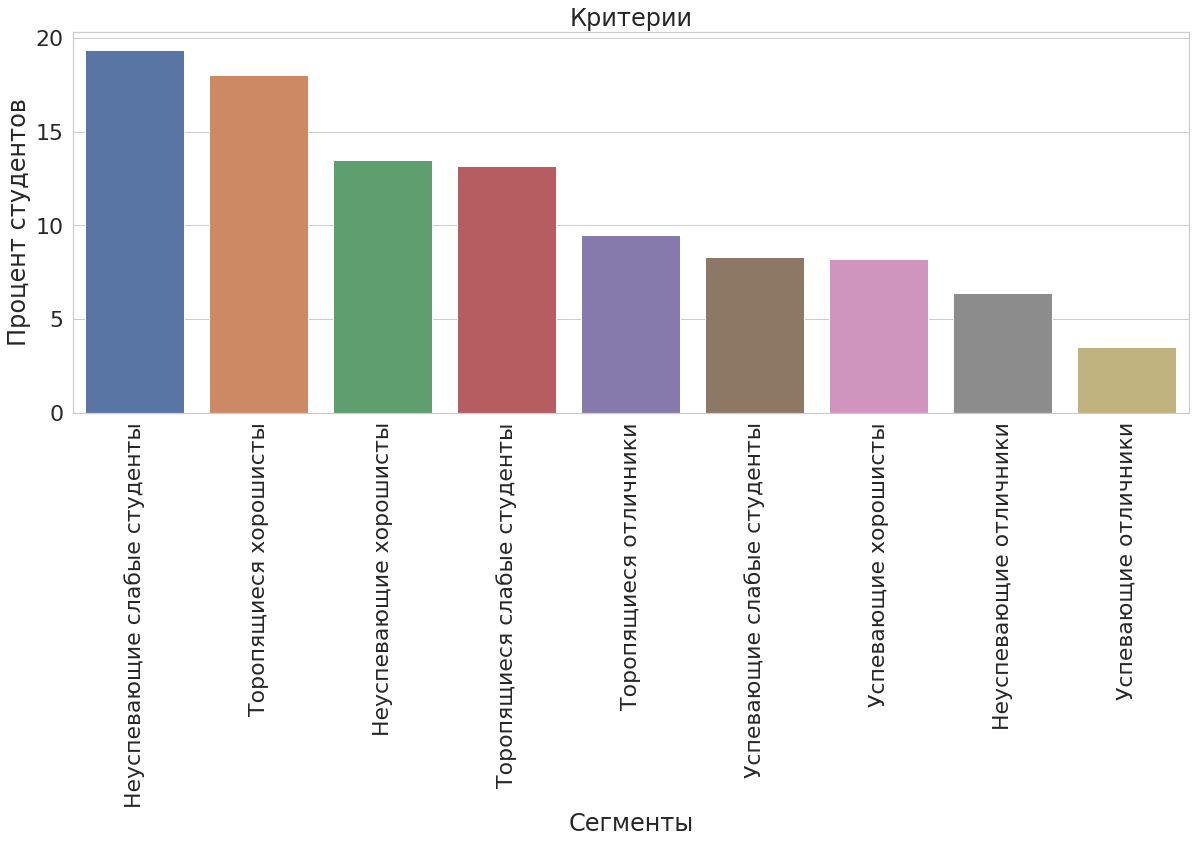

In [33]:
ax = sns.barplot(data=RFM_count, x="segment", y="%")
ax.set_xticklabels(RFM_count.segment, rotation=90)
plt.title('Критерии')
plt.xlabel('Сегменты')
plt.ylabel('Процент студентов')

# Вывод
Наибольшую часть (~ 38 %) составляют неуспевающие слабые студенты и торопящиеся хорошисты
Второе место (~ 26 %) делят студенты из категорий 'Торопящиеся слабые студенты' и 'Неуспевающие хорошисты'
Таким образом, большая половина студентов (~ 64 %), сдающих экзамены либо не успевают, либо торопятся. 
При этом по итоговым оценкам это либо слабые студенты, либо средние (хорошисты)
В свою очередь, отличники всех трех типов составляют ~ 20 % от общей массы
Оставшиеся ~ 16 % составляют успевающие хорошисты и слабые студенты